## Sección de Librerías

In [1]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras
from Plugins import DS

## Descarga de lista de activos a escoger
Esta sección puede dar errores si se pierde la conexión, solo es necesario volver a ejecutar. 

In [2]:
assets = pd.read_csv('Indices/tickers_sp500.csv', index_col=0)['0'].tolist()

## Primera parte, obtención de los activos para el portafolio

In [3]:
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  503 of 503 completed


In [4]:
prices.tail()

A        AAL        AAP        AAPL        ABBV  \
Date                                                                   
2023-06-27  116.816925  17.350000  68.320000  188.059998  132.600006   
2023-06-28  116.148201  17.549999  68.080002  189.250000  132.509995   
2023-06-29  117.825005  17.600000  68.230003  189.589996  133.229996   
2023-06-30  120.250000  17.940001  70.300003  193.970001  134.729996   
2023-07-03  119.320000  18.100000  70.949997  192.460007  135.009995   

                   ABC         ABT       ACGL         ACN        ADBE  ...  \
Date                                                                   ...   
2023-06-27  188.779999  107.790001  71.139999  300.809998  489.269989  ...   
2023-06-28  189.720001  107.610001  71.680000  301.720001  482.429993  ...   
2023-06-29  190.520004  107.660004  73.029999  308.329987  483.769989  ...   
2023-06-30  192.429993  109.019997  74.849998  308.579987  488.989990  ...   
2023-07-03  190.919998  107.220001  73.989998  310.970001  485.209991  ...   

                  WYNN        XEL         XOM       XRAY         XYL  \
Date                                                                   
2023-06-27  105.760002  62.439999  104.550003  39.768833  111.610001   
2023-06-28  104.250000  61.240002  105.400002  39.440002  110.540001   
2023-06-29  104.500000  61.290001  106.699997  39.509998  111.339996   
2023-06-30  105.610001  62.169998  107.250000  40.020000  112.620003   
2023-07-03  106.620003  62.980000  107.459999  39.599998  111.830002   

                   YUM         ZBH        ZBRA       ZION         ZTS  
Date                                                                   
2023-06-27  134.279999  144.809998  282.809998  27.299999  170.669998  
2023-06-28  135.160004  144.000000  283.489990  27.090000  169.100006  
2023-06-29  137.259995  145.149994  288.679993  27.280001  171.869995  
2023-06-30  138.550003  145.600006  295.829987  26.860001  172.210007  
2023-07-03  137.270004  142.509995  296.269989  28.139999  170.229996  

[5 rows x 503 columns]

In [5]:
returns, assets_info= pre_processing.get_assets_info(prices, 99, log_returns=True, drop_per_esg=True)
assets_info #Los rendimientos están con signo al revés 

100%|██████████| 501/501 [01:22<00:00,  6.09it/s]


exp_risk  exp_return  esg_score
A     0.299845    0.105301      0.152
NWL   0.401037    0.497935      0.137
NVR   0.298521   -0.096808      0.203
NVDA  0.577618   -0.361603      0.134
NUE   0.438543   -0.308453      0.319
...        ...         ...        ...
EQIX  0.308775    0.004855      0.118
EOG   0.404629   -0.229283      0.363
EMR   0.255056    0.003747      0.295
EMN   0.326697    0.106040      0.246
ZTS   0.274844    0.058624      0.185

[437 rows x 3 columns]

In [6]:
best_assets = ArchievingStrategies.get_best_opt(assets_info.iloc[:, :2], 1e-6)
best_assets

437it [00:00, 18996.26it/s]


exp_risk  exp_return
PEP  0.167895   -0.137036
ON   0.532355   -0.467451
JNJ  0.160148   -0.012666
MCK  0.220242   -0.408431
MCD  0.173243   -0.141173
ABC  0.212498   -0.266100
HSY  0.186702   -0.200838

In [7]:
fig = my_plotting.plot_assets_plotly(assets_info, best_assets, with_labels=False)
fig.show()

## Segunda Parte, Definición del Problema

In [8]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index], assets_info.loc[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES)

In [9]:
from finquant import efficient_frontier
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
ef_R = ef.efficient_frontier()

## Tercera parte, utilizar distintos muestreos

In [19]:
eps = np.array([0.01,0.01])
colors = ['rgb(141,160,203)', 'rgb(27,158, 119)']

### Markowitz Directed-Search

In [11]:
#Primer paso generar la población eficiente 
def get_Markowitz_directions(size, steps): 
    X_ef = DS.efficient_frontier_weights(ef, size)
    F_ef, ESG_ef = pymoo_extras.eval_weights(portfolio_problem, X_ef)
    FA_ef =  pymoo_extras.annualised_portfolio_quantities(F_ef)
    FA_ef_best = ArchievingStrategies.get_best_opt(FA_ef, 1e-6)
    X_ef= X_ef[FA_ef_best.index]
    ds = DS.DirectedSearch(X_ef[:], PROFITS, RISK, eps, learn_rate=0.001, n_iter=1000)
    X_ef_new = ds.directed_search_full_space(steps)
    return X_ef_new[:]

In [12]:
X_ef = get_Markowitz_directions(1000, 15)
F_ef, ESG_ef = pymoo_extras.eval_weights(portfolio_problem, X_ef)
FA_ef =  pymoo_extras.annualised_portfolio_quantities(F_ef)
FA_ef_best = ArchievingStrategies.get_best_opt(FA_ef, 1e-6)
FA_ef_best_eps = ArchievingStrategies.get_best_opt_eps(FA_ef, 1e-6, eps)
print('Total', FA_ef.shape)
print('Mejores', FA_ef_best.shape)
print('Eps-Mejores', FA_ef_best_eps.shape)

1000it [00:00, 4291.73it/s]
11370it [00:01, 6662.39it/s]
11370it [00:18, 620.92it/s]

Total (11370, 2)
Mejores (1411, 2)
Eps-Mejores (11363, 2)


In [21]:
frames = [FA_ef_best_eps, FA_ef_best]
labels = ['PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

### Con pesos uniformes

In [22]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=10)
F_das, ESG_das = pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das, 1e-6)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
print('Total', FA_das.shape)
print('Mejores', FA_das_best.shape)
print('Eps-Mejores', FA_das_best_eps.shape)


8008it [00:01, 7383.34it/s] 
8008it [00:04, 1817.98it/s]

Total (8008, 2)
Mejores (91, 2)
Eps-Mejores (3423, 2)


In [23]:
frames = [FA_das_best_eps, FA_das_best]
labels = ['PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

### Con Algoritmos Evolutivos

In [24]:
from pymoo.termination import get_termination
termination = get_termination("n_gen", 300)
from pymoo.algorithms.moo.nsga2 import NSGA2
nsgaii = NSGA2(pop_size=40,repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.sms import SMSEMOA
smsemoa = SMSEMOA(pop_size=40, repair=pymoo_extras.Portfolio_Repair())

#### Con NSGA-II

In [25]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii, 1e-6)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
print('Total', FA_nsgaii.shape)
print('Mejores', FA_nsgaii_best.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)

12000it [00:01, 8701.88it/s]
12000it [00:10, 1101.71it/s]

Total (12000, 2)
Mejores (1320, 2)
Eps-Mejores (9295, 2)


In [26]:
frames = [FA_nsgaii_best_eps, FA_nsgaii_best]
labels = ['PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

#### Con SMS-EMOA

In [27]:
X_smsemoa, F_smsemoa, ESG_smsemoa =pymoo_extras.get_weights_with_pymoo(portfolio_problem, smsemoa, termination)
FA_smsemoa =  pymoo_extras.annualised_portfolio_quantities(F_smsemoa)
FA_smsemoa_best = ArchievingStrategies.get_best_opt(FA_smsemoa, 1e-6)
FA_smsemoa_best_eps = ArchievingStrategies.get_best_opt_eps(FA_smsemoa, 1e-6, eps)
print('Total', FA_smsemoa.shape)
print('Mejores', FA_smsemoa_best.shape)
print('Eps-Mejores', FA_smsemoa_best_eps.shape)

12000it [00:02, 5764.47it/s]
12000it [00:14, 816.09it/s]

Total (12000, 2)
Mejores (2243, 2)
Eps-Mejores (10462, 2)


In [28]:
frames = [FA_smsemoa_best_eps, FA_smsemoa_best]
labels = ['PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

## Evaluación 

In [29]:
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
from pymoo.indicators.gd import GD
from sklearn.preprocessing import MinMaxScaler
def get_pfa(name,  fun): 
    if name[0]=='*':
        X_ = fun()
        print(X_.shape)
        F_, ESG_ = pymoo_extras.eval_weights(portfolio_problem, X_)
    else: 
        X_, F_, ESG_ =pymoo_extras.get_weights_with_pymoo(portfolio_problem, fun, termination)
    FA_ = pymoo_extras.annualised_portfolio_quantities(F_)
    #FA_best = ArchievingStrategies.get_best_opt(FA_, 1e-6)
    FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA_, 1e-6, eps)
    return FA_best_eps.to_numpy()

def invert_sign(list_pfa): 
    L = []
    for s in list_pfa:
        s1 = s.copy()
        s1[:, 1] = -s1[:,1]
        L.append(s1)   
    return L  

def eval_GD(pf, list_pfa):  
    ind = GD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]   

def eval_IGD(pf, list_pfa): 
    ind = IGD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]  

def eval_HV(ref_point, list_pfa): 
    scaler = MinMaxScaler()
    Ftest = np.vstack(list_pfa)
    scaler.fit(Ftest)
    ind = HV(ref_point=ref_point)
    return [ind(scaler.transform(A)) for A in list_pfa]

algs = {'*Markowitz' : lambda : get_Markowitz_directions(1000, 15), 
        '*das-dennis': lambda : get_reference_directions("das-dennis", len(PROFITS), n_partitions=10), 
        'nsgaii': nsgaii, 
        'sms-emoa':smsemoa}

def full_evaluation(iters, algs, pf, ref_point):
    metric_eval = {'GD': [], 'IGD': [], 'HV': []}
    metrics = {'GD': lambda x: eval_GD(pf, x), 
               'IGD':lambda x: eval_IGD(pf, x), 
               'HV': lambda x: eval_HV(ref_point, x)}
    for i in range(iters): 
        results = [ get_pfa(name, par) for name, par in algs.items()]
        for indicator in metrics.keys(): 
            metric_eval[indicator].append(metrics[indicator](results[:]))
    
    metric_eval_means = {}
    for indicator in metric_eval.keys(): 
        metric_eval_means[indicator+'mean']=np.mean( np.array(metric_eval[indicator]), axis=0)
        metric_eval_means[indicator+'std'] = np.std( np.array(metric_eval[indicator]), axis=0)
    
    return pd.DataFrame(metric_eval_means, index = algs.keys())

In [30]:
#evaluation = full_evaluation(20, algs, ef_R, np.array([1.1,1.1]))
#evaluation

## Gráficas de Interés Muestreo Ganador

In [31]:
X, F, ESG =pymoo_extras.get_weights_with_pymoo(portfolio_problem,smsemoa, termination)
FA =  pymoo_extras.annualised_portfolio_quantities(F)
FA_best = ArchievingStrategies.get_best_opt(FA, 1e-6)
FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA, 1e-6, eps)

FA_3D = FA_best_eps.copy()
FA_3D['exp_esg'] = ESG[FA_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)

print('Total', FA.shape)
print('Mejores', FA_best.shape)
print('Eps-Mejores', FA_best_eps.shape)
print('Mejores 3D', FA_3D_best.shape)

12000it [00:01, 6890.19it/s]
12000it [00:13, 896.89it/s]
10431it [00:03, 2687.08it/s]

Total (12000, 2)
Mejores (2213, 2)
Eps-Mejores (10431, 2)
Mejores 3D (3933, 3)


In [32]:
frames = [FA, FA_best_eps, FA_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)
fig.show()

In [33]:
## Correciones de signos 
#En dos objetivos
FA_best['exp_return'] = -FA_best['exp_return']
FA_best['exp_esg'] =  ESG[FA_best.index] 
#En tres objetivos
FA_3D_best['exp_return'] = - FA_3D_best['exp_return']
FA_3D['exp_return'] = - FA_3D['exp_return']
FA_3D['Type'] = 'PQ-eps 2obj'
FA_3D.loc[FA_3D_best.index, 'Type']='PQ 3obj'

In [34]:
fig = my_plotting.plotting_projection_plotly(FA_3D_best, ef_R)
fig.show()

[]

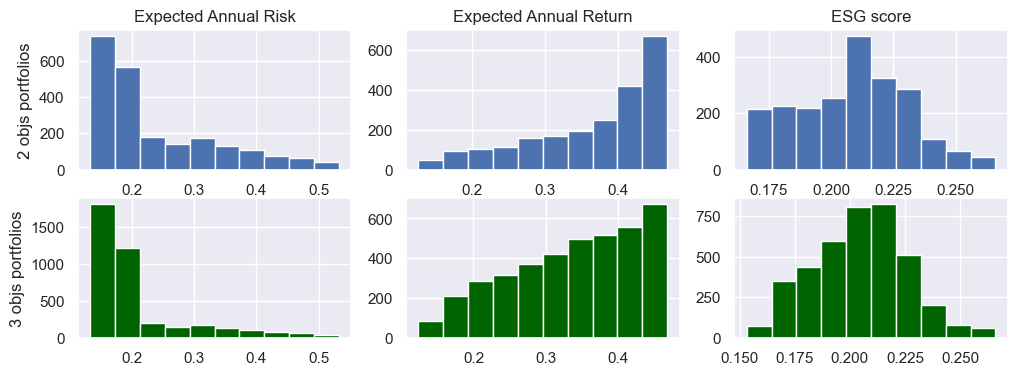

In [35]:
fig = my_plotting.plot_histograms(FA_best, FA_3D_best)
plt.plot()

[]

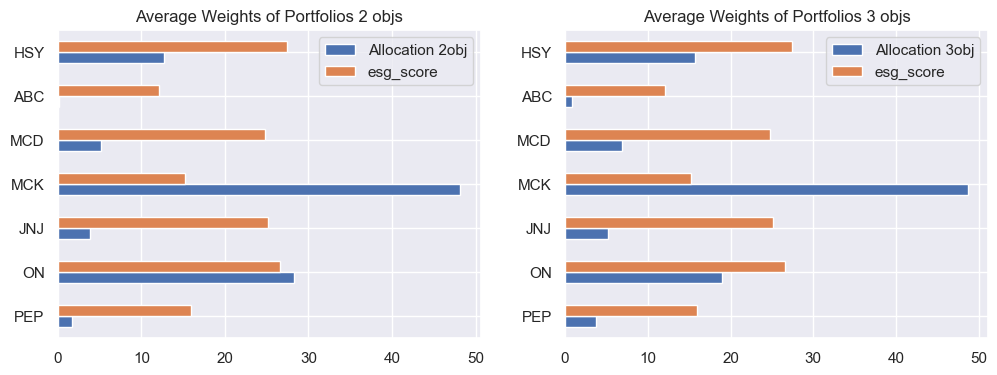

In [36]:
fig = my_plotting.plot_proportions(FA_best, FA_3D_best, X,best_assets, assets_info)
plt.plot()